# Predicting Health Insurance

---

## Importing Libraries

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, make_scorer
from imblearn.over_sampling import SMOTE
import matplotlib.image as mpimg

In [431]:
custom_palette = ['#7464D1', '#451176']
sns.set_palette(custom_palette)

---

## Loading Data

In [432]:
df = pd.read_csv('../HealthInsurancePredictor/data/customer.csv')

df.head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


---

## Data Exploration

In [433]:
# Display the shape of the DataFrame (number of rows and columns)
df.shape

(72458, 15)

In [434]:
# Display information about the DataFrame including data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


In [435]:
# Display summary statistics of the DataFrame
df.describe()

,Unnamed: 0,income,num_vehicles,age,code_column,gas_usage,rooms
count,72458.000000,7.245800e+04,70772.000000,72458.000000,72458.000000,70772.000000,72458.000000
mean,49910.637556,4.188143e+04,2.066820,49.208893,3285.523572,41.230501,3.494549
std,28772.082702,5.827460e+04,1.170076,18.090035,2661.775225,63.149323,1.706537
min,7.000000,-6.900000e+03,0.000000,0.000000,131.000000,1.000000,1.000000
25%,24911.250000,1.070000e+04,1.000000,34.000000,1305.000000,3.000000,2.000000
50%,49838.000000,2.640000e+04,2.000000,48.000000,2269.000000,10.000000,3.000000
75%,74786.750000,5.200000e+04,3.000000,62.000000,4979.000000,60.000000,5.000000
max,100000.000000,1.257000e+06,6.000000,120.000000,8962.000000,570.000000,6.000000


In [436]:
# Print the number of null values for each column
print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
Unnamed: 0            0
custid                0
sex                   0
is_employed       25515
income                0
marital_status        0
health_ins            0
housing_type       1686
num_vehicles       1686
age                   0
state_of_res          0
code_column           0
gas_usage          1686
rooms                 0
recent_move_b      1687
dtype: int64


In [437]:
# Print the number of duplicate rows
print("\nDuplicate rows:")
print(df.duplicated().sum())


Duplicate rows:
0


In [438]:
# Print the number of unique values for each column
print("\nUnique values per column:")
print(df.nunique())


Unique values per column:
Unnamed: 0        72458
custid            72458
sex                   2
is_employed           2
income             4445
marital_status        4
health_ins            2
housing_type          4
num_vehicles          7
age                  81
state_of_res         51
code_column          49
gas_usage            57
rooms                 6
recent_move_b         2
dtype: int64


---

## Data Preprocessing

# Brief Analysis of the Columns

## Unnecessary Columns:

- `Unnamed: 0` - This column functions as an index, so it is irrelevant and can be removed.

- `custid` - The ID of each customer is also unnecessary for the analysis and will be removed as well.

- `code_column` - The column containing the code is likewise irrelevant.

## Necessary Columns:

- The columns: `sex`, `is_employed`, `income`, `marital_status`, **`health_ins`**, `housing_type`, `num_vehicles`, `age`, `state_of_res`, `gas_usage`, `rooms`, and `recent_move_b` are all relevant for predicting the primary variable **`health_ins`**.


### Drop unnecessary columns

In [439]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'custid', 'code_column'], errors='ignore')

df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b
0,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,210.0,3,F
1,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,3.0,6,T
2,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,40.0,3,F
3,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,120.0,2,F
4,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,3.0,2,F


### Handling missing values

#### Handling missing values in is_employed column

These will be the NaN values that will require more attention when handled, as they represent a significant portion: 25,515 out of 72,457, approximately 35.2%.

The way we will handle them is as follows:
   - People under 16 years old -> we will assume they are not employed.
   - People with an income of 0 -> we will assume they are not employed.
   - People who have an income and are over 16 years old -> we will assume they are employed.

In [440]:
# Display the count of unique values for the 'is_employed' column, including NaN values
df['is_employed'].value_counts(dropna=False)

is_employed
True     44630
NaN      25515
False     2313
Name: count, dtype: int64

In [441]:
df['is_employed'] = df['is_employed'].fillna('Not in Workforce')

df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b
0,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,210.0,3,F
1,Female,Not in Workforce,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,3.0,6,T
2,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,40.0,3,F
3,Female,Not in Workforce,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,120.0,2,F
4,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,3.0,2,F


#### Handling missing values in the rest of the columns

In [442]:
# Check for missing rows in the four columns
missing_housing = df['housing_type'].isnull()
missing_vehicles = df['num_vehicles'].isnull()
missing_gas = df['gas_usage'].isnull()
missing_recent_move = df['recent_move_b'].isnull()

# Verify if the counts match and print results
print("Total missing in housing_type:", missing_housing.sum())
print("Total missing in num_vehicles:", missing_vehicles.sum())
print("Total missing in gas_usage:", missing_gas.sum())
print("Total missing in recent_move_b:", missing_recent_move.sum())

Total missing in housing_type: 1686
Total missing in num_vehicles: 1686
Total missing in gas_usage: 1686
Total missing in recent_move_b: 1687


We noticed that only `recent_move_b` has one more NaN than the other three columns. Therefore, we can check if the other three columns share the same NaN values, and if they do, we can remove these rows, as they represent a minimal percentage of the dataset, only **2.3% of the dataset**.
This approach ensures data quality while retaining 97.7% of the data for analysis and modeling.

In [443]:
nan_rows = df[(df['housing_type'].isna()) & 
              (df['num_vehicles'].isna()) & 
              (df['gas_usage'].isna())]

same_nan_count = nan_rows.shape[0]
print(f"Number of rows with simultaneous NaNs: {same_nan_count}")

Number of rows with simultaneous NaNs: 1686


Now that we know the NaNs are in the same rows simultaneously, we can remove these rows and check if there are still any NaNs remaining in `recent_move_b`.

In [444]:
#apagar as linhas
'''rows_to_drop = df[(df['housing_type'].isnull()) &
                  (df['num_vehicles'].isnull()) &
                  (df['gas_usage'].isnull())].index
df = df.drop(rows_to_drop)

print("\nNull values per column:")
print(df.isnull().sum())'''

'rows_to_drop = df[(df[\'housing_type\'].isnull()) &\n                  (df[\'num_vehicles\'].isnull()) &\n                  (df[\'gas_usage\'].isnull())].index\ndf = df.drop(rows_to_drop)\n\nprint("\nNull values per column:")\nprint(df.isnull().sum())'

In [445]:
#trocar os valores
df['housing_type'] = df['housing_type'].fillna('Unknown')
df['num_vehicles'] = df['num_vehicles'].fillna(0)
df['gas_usage'] = df['gas_usage'].fillna(0)

print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
sex                  0
is_employed          0
income               0
marital_status       0
health_ins           0
housing_type         0
num_vehicles         0
age                  0
state_of_res         0
gas_usage            0
rooms                0
recent_move_b     1687
dtype: int64


We are left with only one NaN in `recent_move_b`, which means the other 1686 were also shared. With this, we can remove this last row.

In [446]:
#apagar as linhas
'''df = df.dropna(subset=['recent_move_b'])

print("\nNull values per column:")
print(df.isnull().sum())'''

'df = df.dropna(subset=[\'recent_move_b\'])\n\nprint("\nNull values per column:")\nprint(df.isnull().sum())'

In [447]:
#trocar os valores
df['recent_move_b'] = df['recent_move_b'].fillna('Unknown')

print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
sex               0
is_employed       0
income            0
marital_status    0
health_ins        0
housing_type      0
num_vehicles      0
age               0
state_of_res      0
gas_usage         0
rooms             0
recent_move_b     0
dtype: int64


### Handling outliers

In [448]:
# Numerical features to evaluate for outliers
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms']

#### Detecting outliers

##### Distribution plots 

This section visualizes the distribution of numerical features to observe their overall shape and detect potential skewness or outliers. Features with a strong skew might require transformations before modeling.

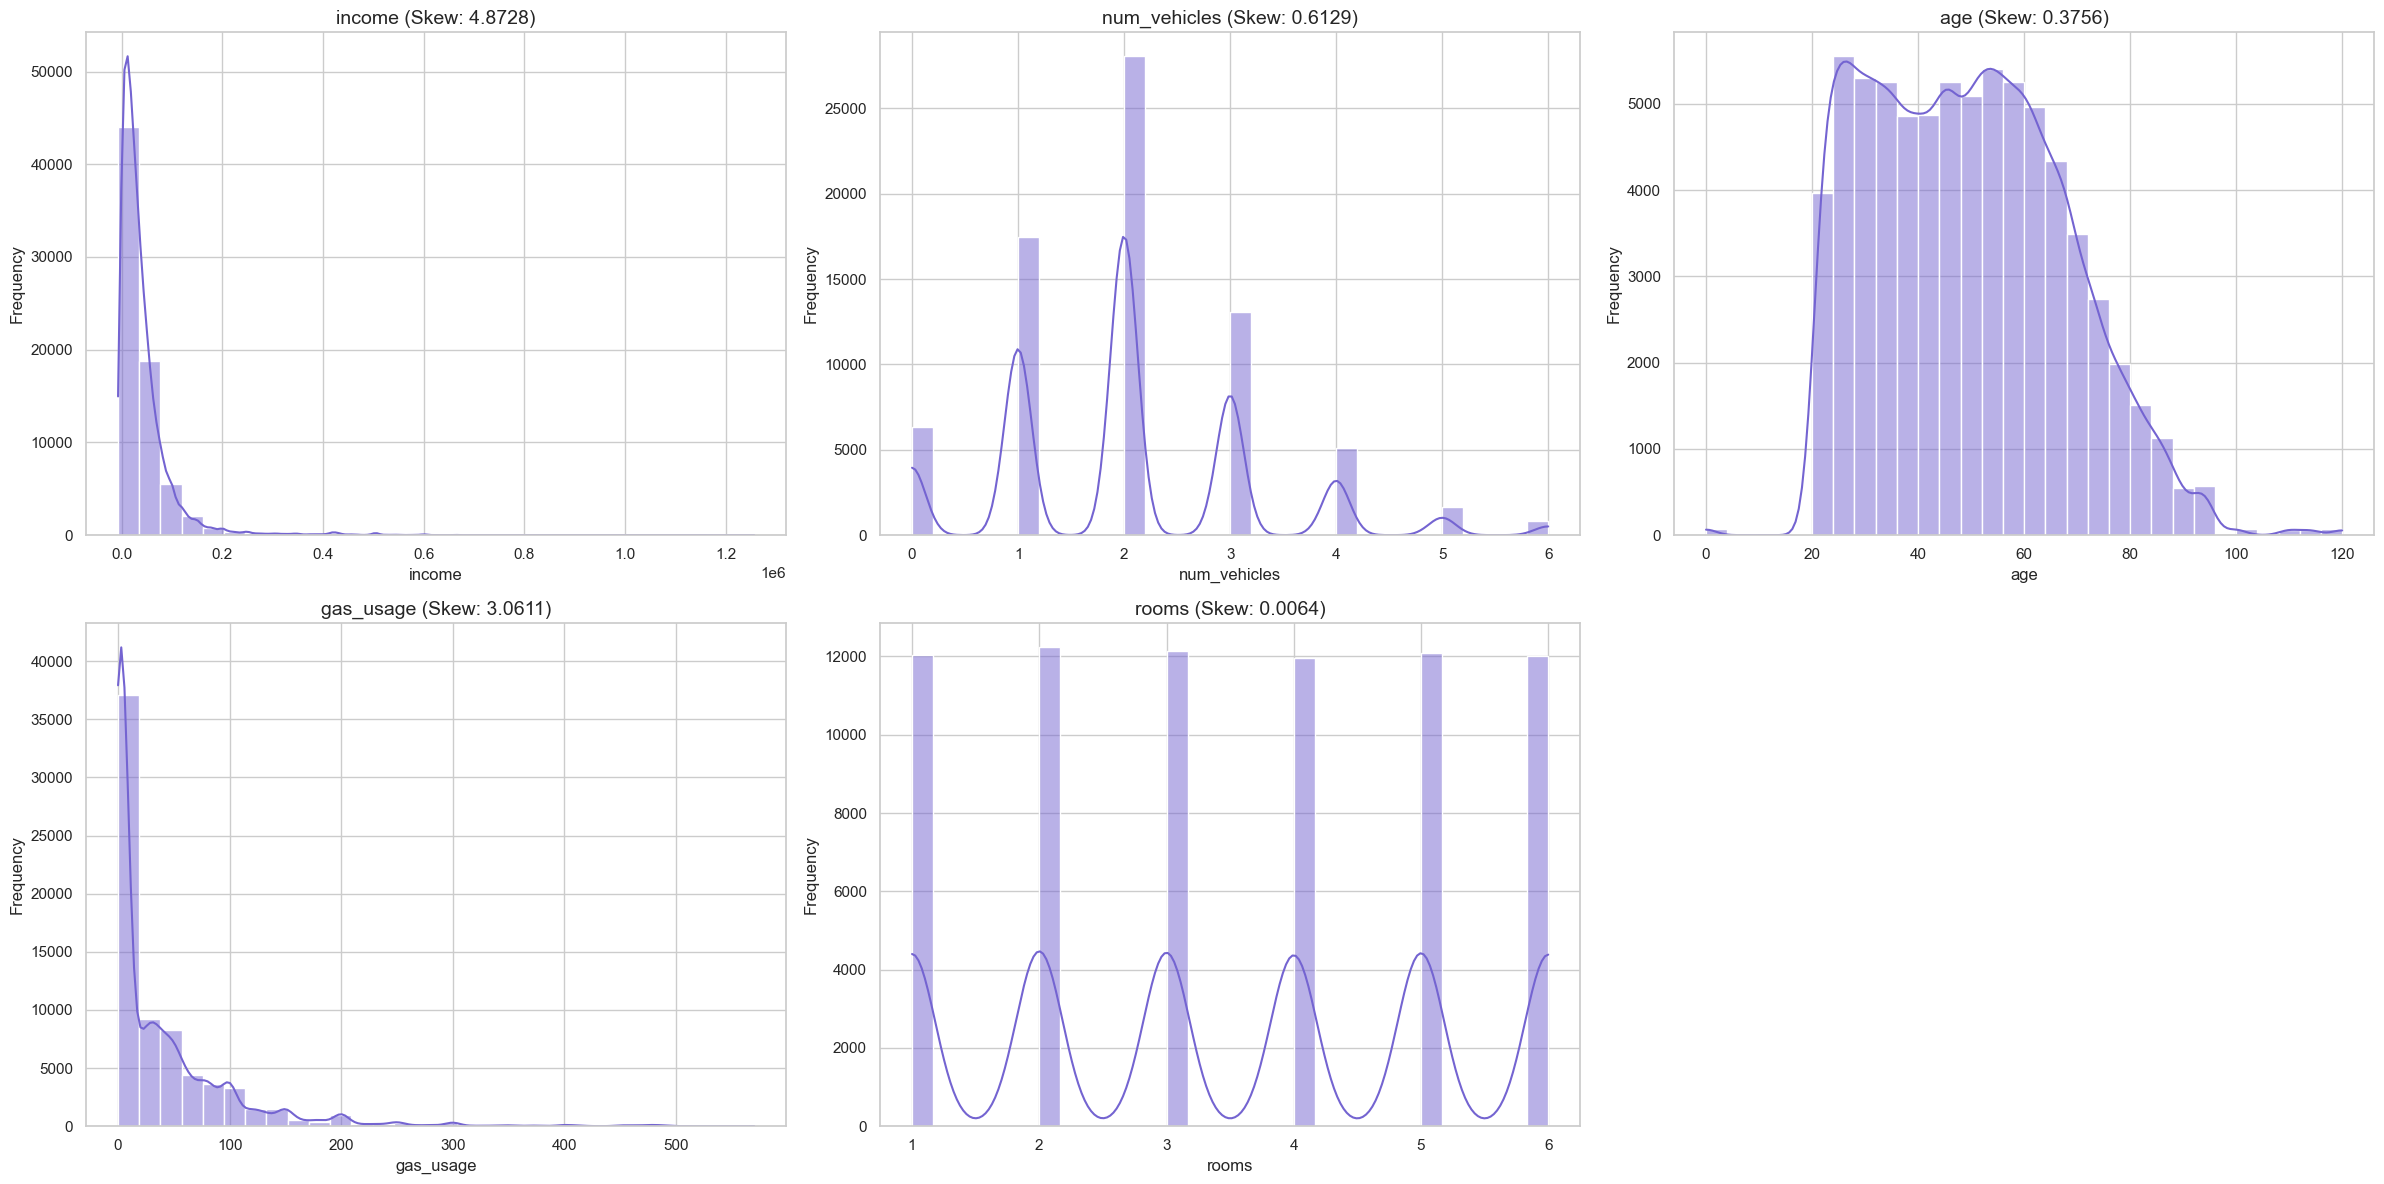

In [449]:
color = custom_palette[0]

# Plot distribution of numerical features with skewness information
f, axes = plt.subplots(2, 3, figsize=(24, 12)) 
axes = axes.flatten()

# Loop through numerical features
for i, col in enumerate(df[numerical_features].columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color=color)
    axes[i].set_title(f'{col} (Skew: {df[col].skew():.4f})', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Hide any unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

##### Box Plots

Boxplots visually represent the spread of data and highlight potential outliers as points outside the whiskers.

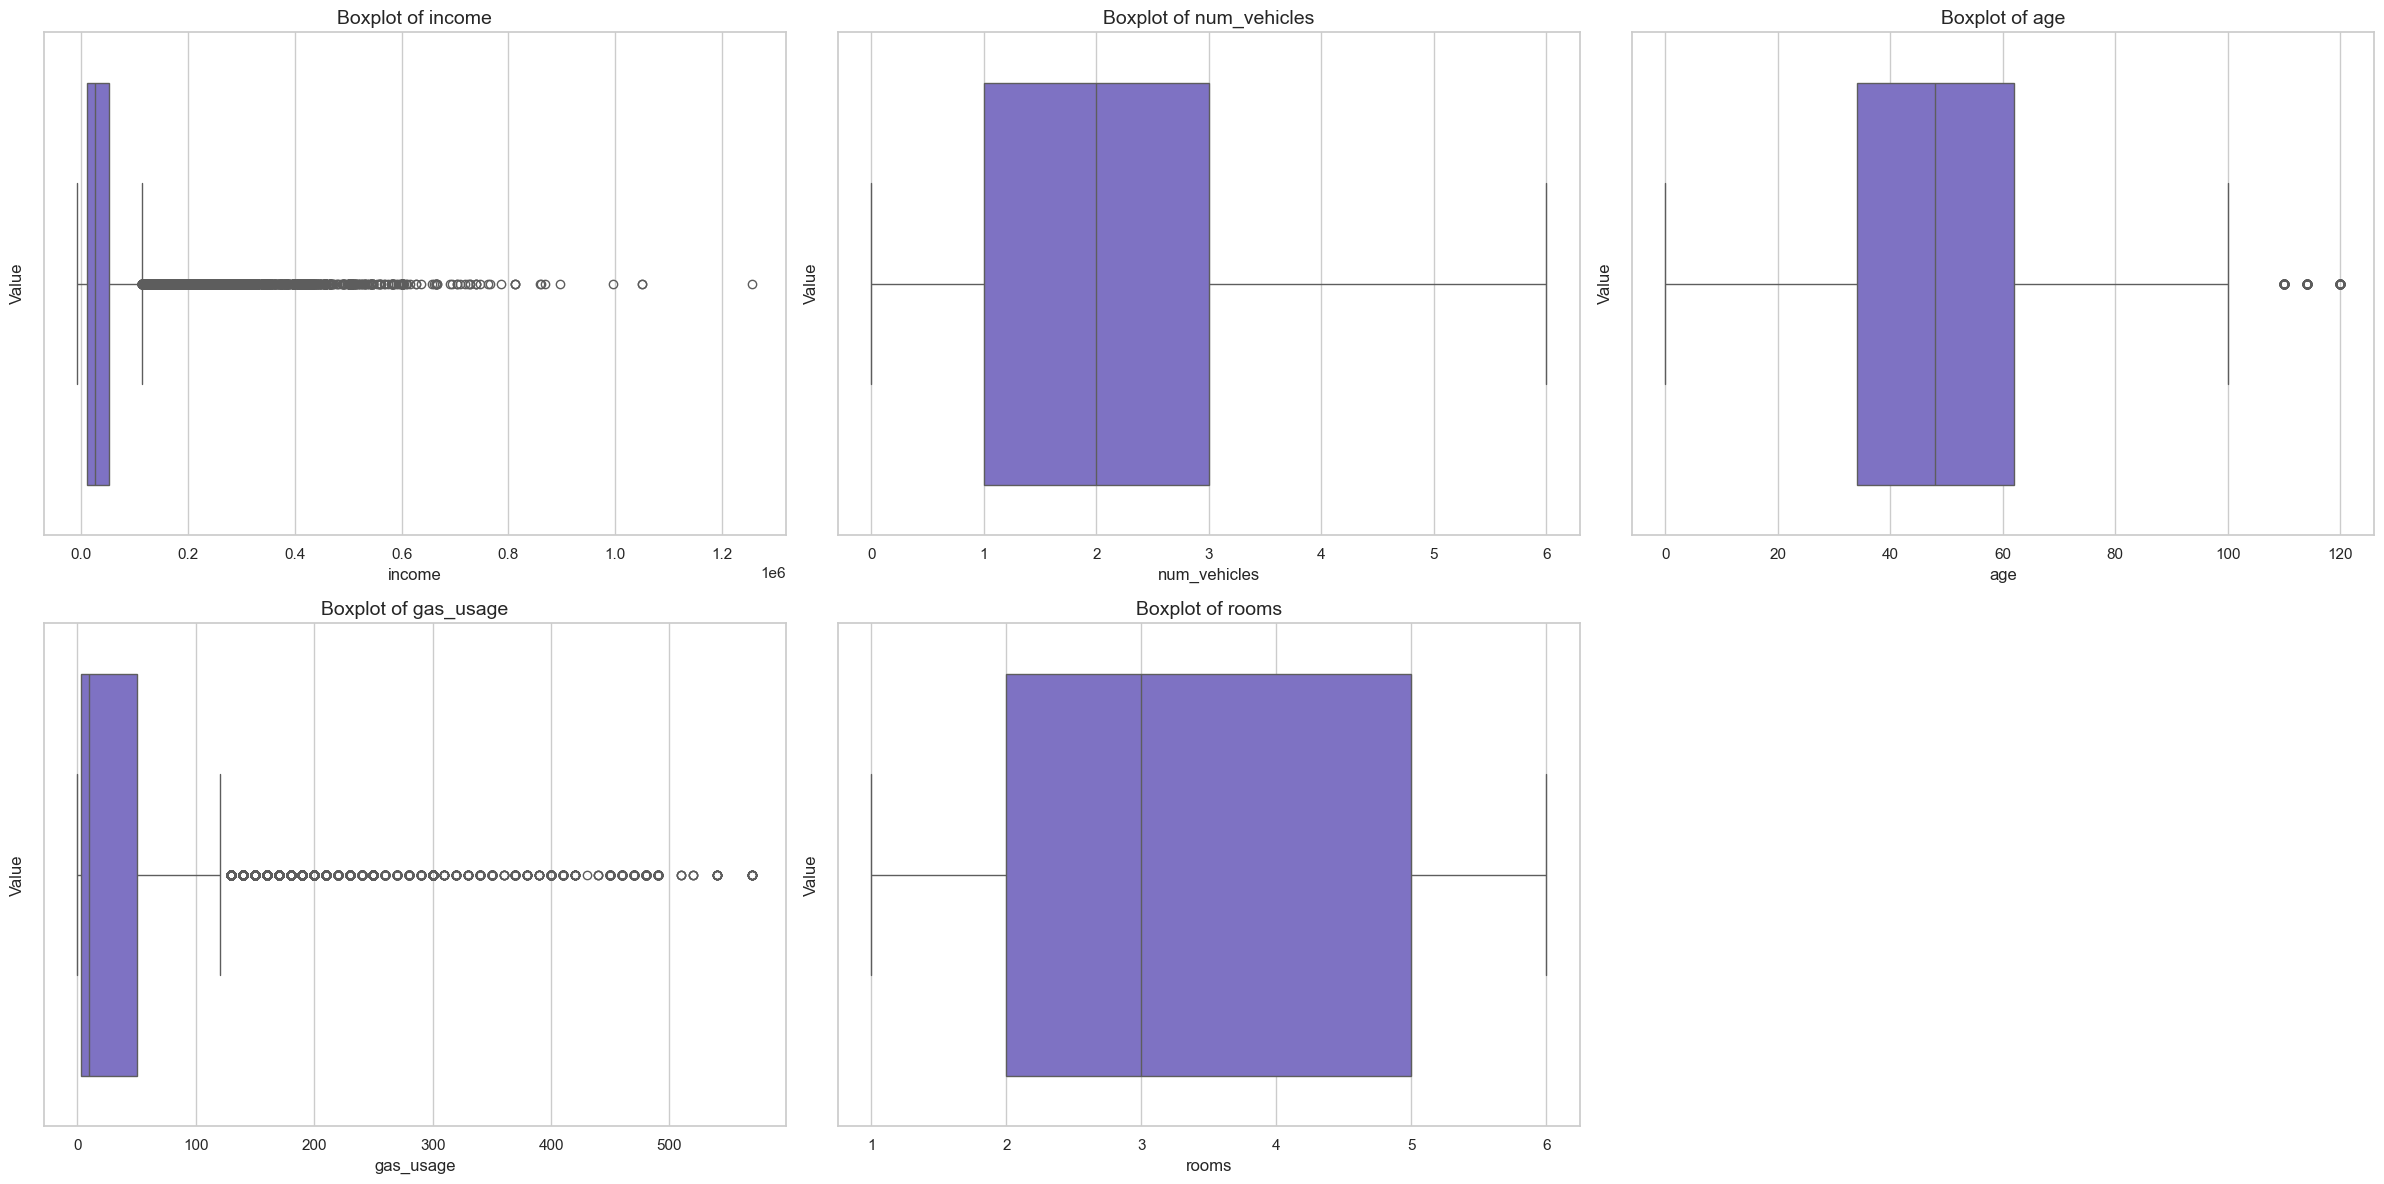

In [450]:
sns.set_theme(style="whitegrid")

f, axes = plt.subplots(2, 3, figsize=(24, 12))  
axes = axes.flatten()

# Loop through numerical features and plot each
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i], color=color)
    axes[i].set_title(f'Boxplot of {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Value', fontsize=12)

# Hide unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


##### Scatter Plots

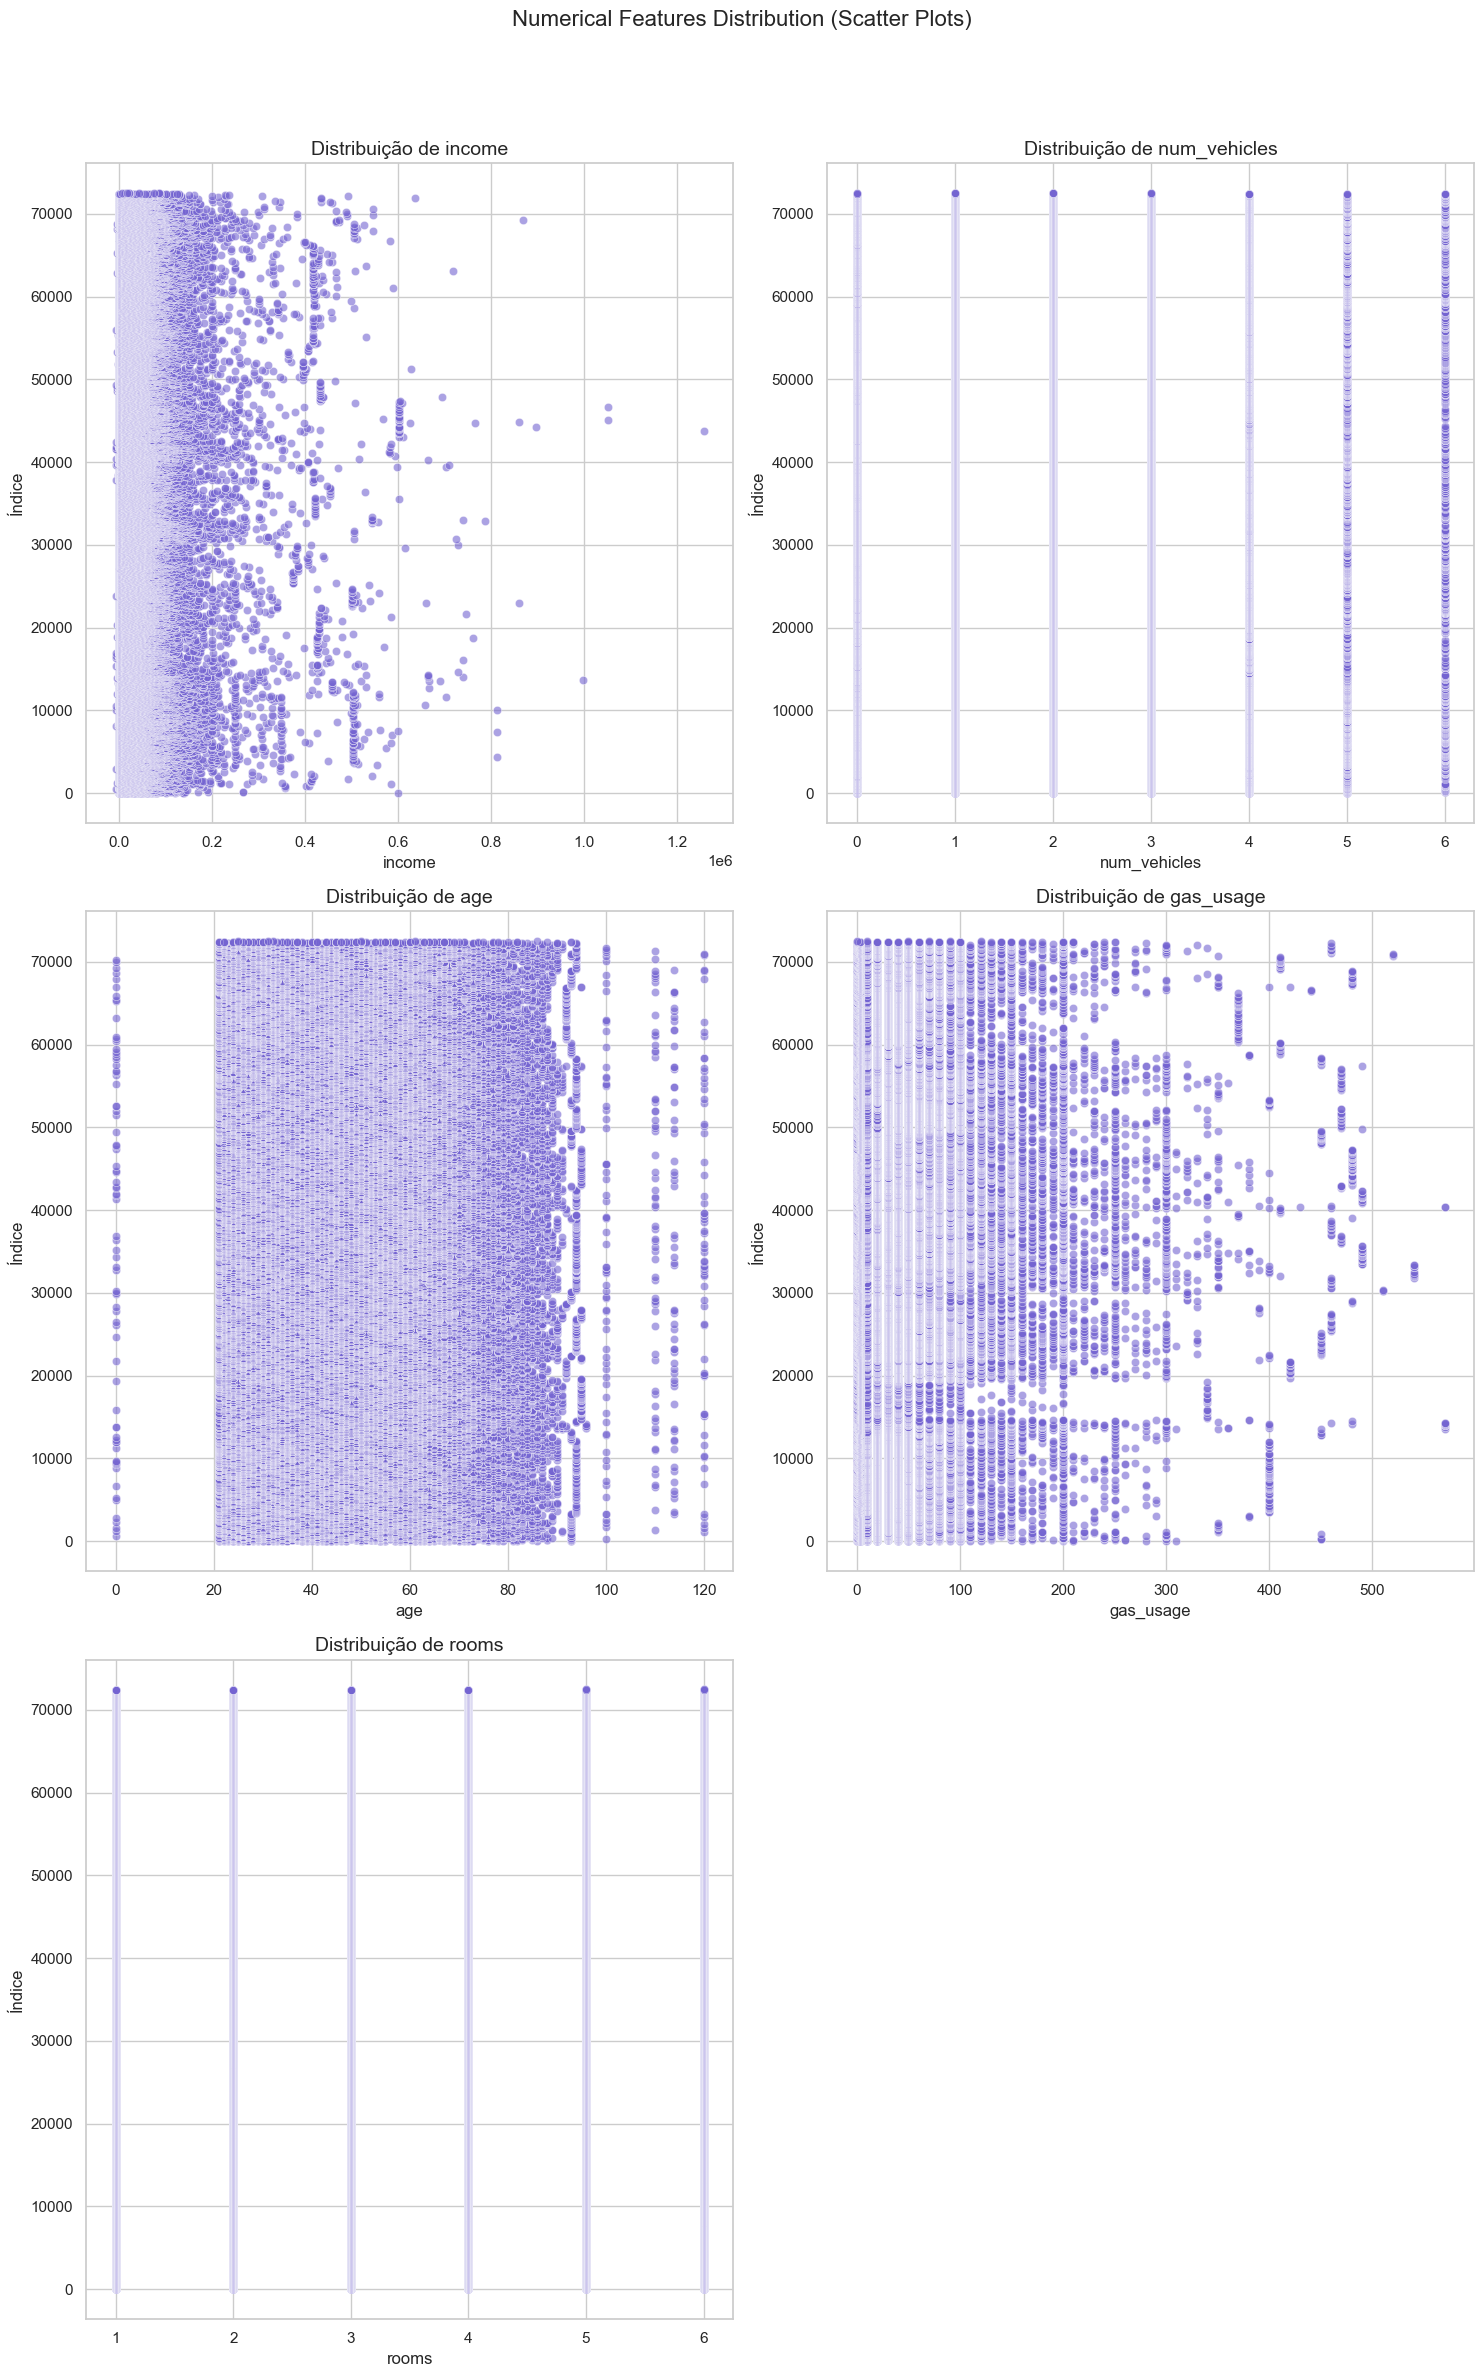

In [451]:
# Scatter plots to visualize relationships
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 25))

color = custom_palette[0]

# Create a scatter plot for each numerical feature
for i, feature in enumerate(numerical_features[:5], 1):
    plt.subplot(3, 2, i)  
    sns.scatterplot(data=df, x=feature, y=df.index, alpha=0.6, color=color)
    plt.title(f'Distribuição de {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Índice', fontsize=12)

plt.suptitle('Numerical Features Distribution (Scatter Plots)', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Outliers we need to handle

- **gas_usage**
- **age**
- **income**

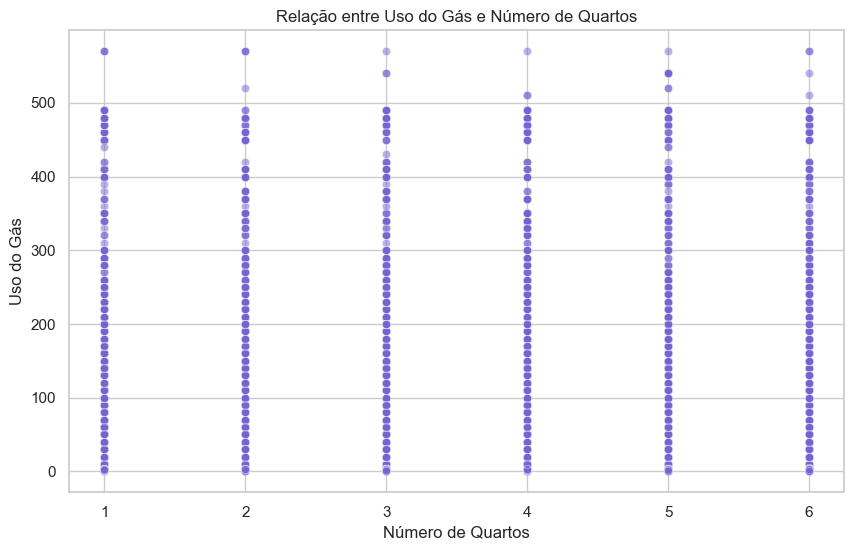

In [452]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='rooms', y='gas_usage', alpha=0.5,color=color)
plt.title('Relação entre Uso do Gás e Número de Quartos')
plt.xlabel('Número de Quartos')
plt.ylabel('Uso do Gás')
plt.show()

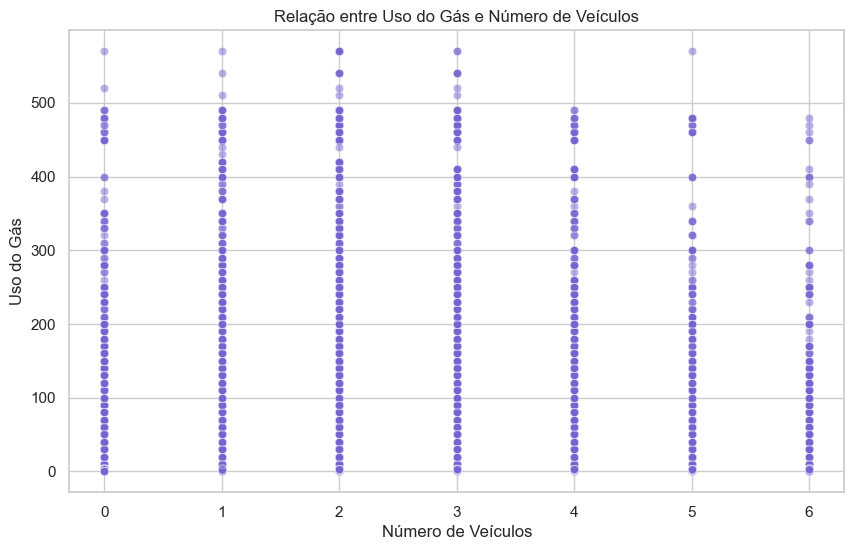

In [453]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_vehicles', y='gas_usage', alpha=0.5,color=color)
plt.title('Relação entre Uso do Gás e Número de Veículos')
plt.xlabel('Número de Veículos')
plt.ylabel('Uso do Gás')
plt.show()

# Outliers in gas_usage

In [454]:
Q1 = df['gas_usage'].quantile(0.25)
Q3 = df['gas_usage'].quantile(0.75)
IQR = Q3 - Q1

# Define limits for outliers
gas_lower_limit = Q1 - 1.5 * IQR
gas_upper_limit = Q3 + 1.5 * IQR

# Count the outliers
outliers = df[(df['gas_usage'] < gas_lower_limit) | (df['gas_usage'] > gas_upper_limit)]
outlier_count = outliers.shape[0]

print(f"Number of outliers: {outlier_count}")


Number of outliers: 5727


We noticed that there is a significant amount of outliers in this variable. Therefore, we should not simply remove them. However, by analyzing the boxplot of this variable, we observed that the outliers are most likely annual values. Thus, a good approach would be to divide these values by 12, so that all values are within the same unit of measure.


# AQUI TEMOS DE ESCOLHER

## Se dividirmos por 12 de forma a ficarem todos mensais

In [455]:
#df.loc[df['gas_usage'] > upper_limit, 'gas_usage'] /= 12

## gas_usage with log

In [456]:
df['gas_usage'] = np.log1p(df['gas_usage'])

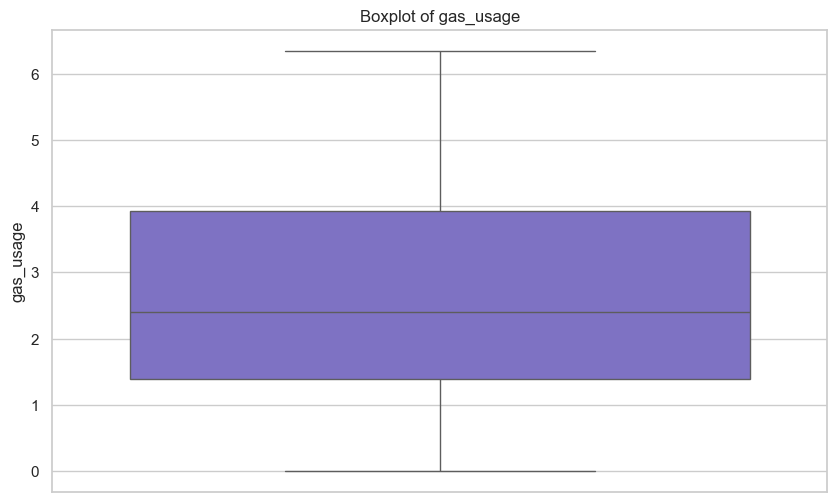

In [457]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='gas_usage', color=color)
plt.title('Boxplot of gas_usage')
plt.ylabel('gas_usage')
plt.show()

# Outliers in age

In [458]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

age_upper_limit = Q3 + 1.5 * IQR

print(f"Upper limit: {age_upper_limit}")

age_outliers = df[df['age'] > age_upper_limit]
age_outliers_count = age_outliers.shape[0]
print(f"Number of outliers: {age_outliers_count}")

Upper limit: 104.0
Number of outliers: 191


Since there are only 186 values, which is less than 0.5% of the dataset, we will remove these values.

In [459]:
#df = df[df['age'] <= age_upper_limit]

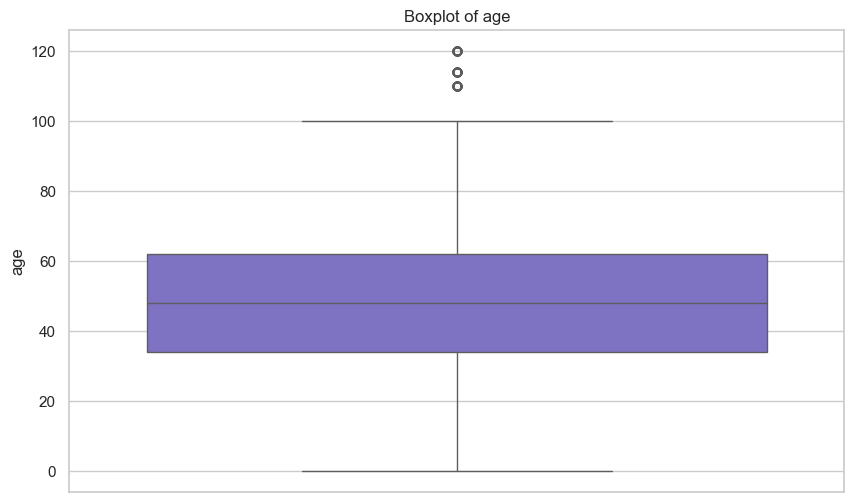

In [460]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='age',color=color)
plt.title('Boxplot of age')
plt.ylabel('age')
plt.show()

# Outliers in income

In [461]:
Q1 = df['income'].quantile(0.25)
Q3 = df['income'].quantile(0.75)
IQR = Q3 - Q1

income_upper_limit = Q3 + 1.5 * IQR

print(f"Upper limit: {income_upper_limit}")

income_outliers = df[df['income'] > income_upper_limit]
income_outliers_count = income_outliers.shape[0]
print(f"Number of outliers: {income_outliers_count}")

Upper limit: 113950.0
Number of outliers: 4512


In [462]:
df.loc[df['income'] > income_upper_limit, 'income'] /= 12

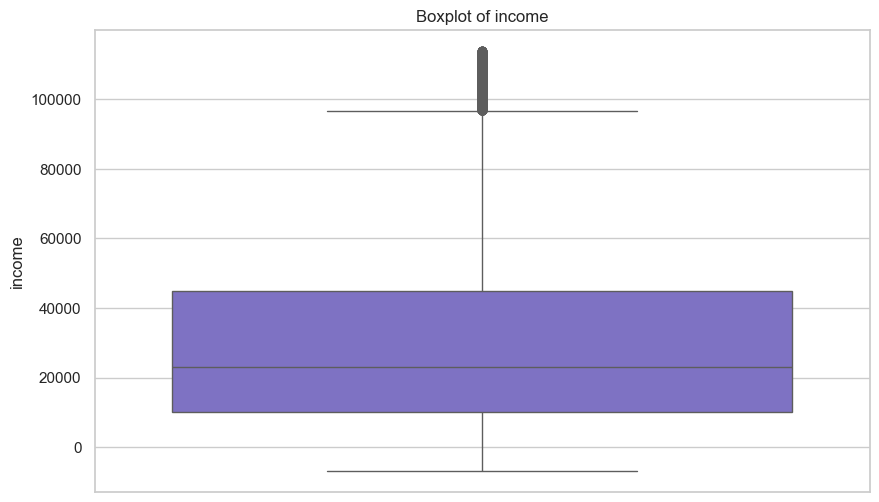

In [463]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='income',color=color)
plt.title('Boxplot of income')
plt.ylabel('income')
plt.show()

# adicionar colunas para ajudar o modelo

In [464]:
# Create age bins
df['age_group'] = pd.cut(df['age'], bins=[-1, 18, 35, 55, 75, 100, 145], labels=[0, 1, 2, 3, 4, 5])

# Create income per vehicle
df['income_per_vehicle'] = df['income'] / (df['num_vehicles'] + 1)  # Avoid division by zero

df['income_age_interaction'] = df['income'] * df['age']

# começar a preparar os modelos

##  Label encoding and binarization

In [465]:
df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b,age_group,income_per_vehicle,income_age_interaction
0,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,5.351858,3,F,1,22000.0,528000.0
1,Female,Not in Workforce,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1.386294,6,T,4,23200.0,1902400.0
2,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,3.713572,3,F,1,7000.0,651000.0
3,Female,Not in Workforce,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,4.795791,2,F,4,18885.0,3512610.0
4,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1.386294,2,F,3,13000.0,2613000.0


In [466]:
# Dicionários de mapeamento para label encoding
sex_mapping = {'Female': 0, 'Male': 1}
is_employed_mapping = {False: 0, True: 1, 'Not in Workforce': 2}
marital_status_mapping = {'Divorced/Separated': 0, 'Married': 1, 'Never married': 2, 'Widowed': 3}
housing_type_mapping = {'Homeowner free and clear': 0, 'Homeowner with mortgage/loan': 1, 'Occupied with no rent': 2, 'Rented': 3, 'Unknown': 4}
recent_move_b_mapping = {'F': 0, 'T': 1, 'Unknown': 2}
health_ins_mapping = {False: 0, True: 1, 'Not in Workforce': 2}

# Aplicar mapeamento nas colunas categóricas
df['sex'] = df['sex'].map(sex_mapping)
df['is_employed'] = df['is_employed'].map(is_employed_mapping)
df['marital_status'] = df['marital_status'].map(marital_status_mapping)
df['housing_type'] = df['housing_type'].map(housing_type_mapping)
df['recent_move_b'] = df['recent_move_b'].map(recent_move_b_mapping)
df['health_ins'] = df['health_ins'].map(health_ins_mapping)

# Label encoding para 'state_of_res' com 51 valores possíveis
state_of_res_le = LabelEncoder()
age_group_le = LabelEncoder()
df['state_of_res'] = state_of_res_le.fit_transform(df['state_of_res'])
df['age_group'] = age_group_le.fit_transform(df['age_group'])

df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b,age_group,income_per_vehicle,income_age_interaction
0,1,1,22000.0,2,1,0,0.0,24,0,5.351858,3,0,1,22000.0,528000.0
1,0,2,23200.0,0,1,3,0.0,82,0,1.386294,6,1,4,23200.0,1902400.0
2,0,1,21000.0,2,1,1,2.0,31,0,3.713572,3,0,1,7000.0,651000.0
3,0,2,37770.0,3,1,0,1.0,93,0,4.795791,2,0,4,18885.0,3512610.0
4,1,1,39000.0,0,1,3,2.0,67,0,1.386294,2,0,3,13000.0,2613000.0


#### começamos com um problema, que há uma grande disparidade entre o numero de true e o numero de falses

In [467]:
print(df['health_ins'].value_counts())

health_ins
1    65553
0     6905
Name: count, dtype: int64


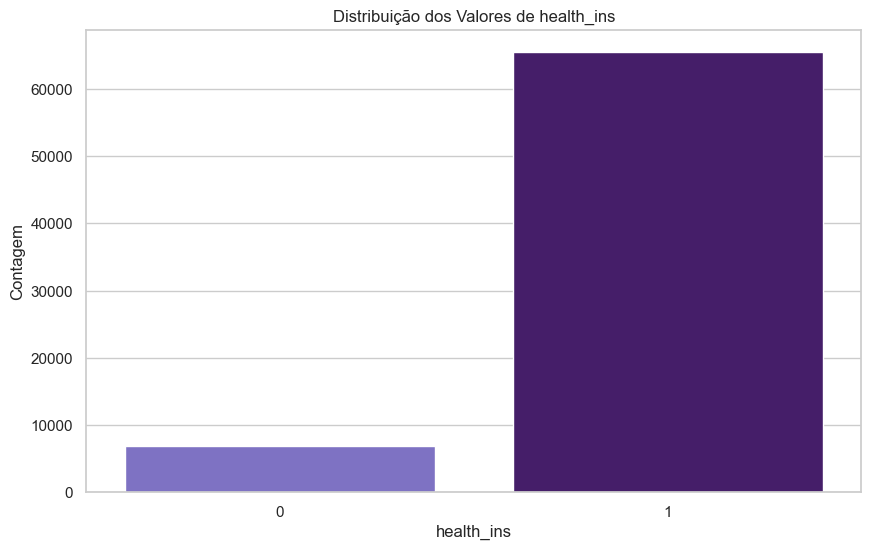

In [468]:
# Plotar a contagem dos valores de health_ins
plt.figure(figsize=(10, 6))
sns.countplot(x='health_ins', data=df, hue='health_ins', palette=custom_palette, legend=False)
plt.title('Distribuição dos Valores de health_ins')
plt.xlabel('health_ins')
plt.ylabel('Contagem')
plt.show()

# Smote

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_64511/1958541317.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='health_ins', data=df, palette=custom_palette, legend=False)


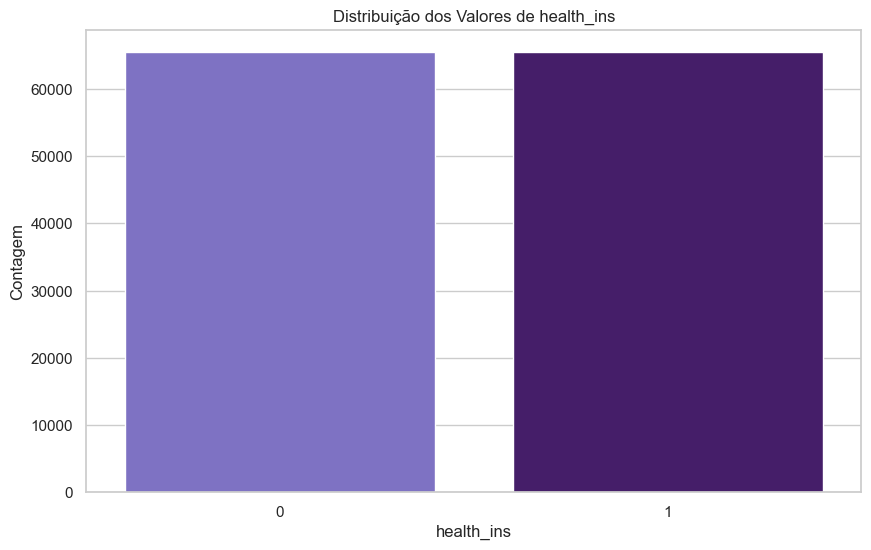

In [469]:
smt = SMOTE(random_state=5)
X = df.drop('health_ins', axis = 1)
y = df['health_ins']
X, y = smt.fit_resample(X, y)
df = pd.concat([X, y], axis=1)

# Plotar a contagem dos valores de health_ins
plt.figure(figsize=(10, 6))
sns.countplot(x='health_ins', data=df, palette=custom_palette, legend=False)
plt.title('Distribuição dos Valores de health_ins')
plt.xlabel('health_ins')
plt.ylabel('Contagem')
plt.show()

In [470]:
# separar as features e a variável alvo
X = df.drop(columns=['health_ins'])
y = df['health_ins']

# dividir os dados em treino e teste (80-20)
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X, y, test_size=0.01, random_state=1)

default_results = {}

# knn

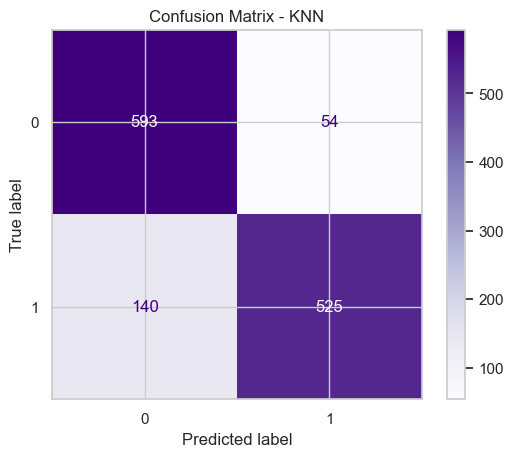

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       647
           1       0.91      0.79      0.84       665

    accuracy                           0.85      1312
   macro avg       0.86      0.85      0.85      1312
weighted avg       0.86      0.85      0.85      1312



In [471]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(training_inputs, training_classes)
knn_predictions = knn_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, knn_predictions, average='weighted')
accuracy = knn_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])

default_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, knn_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix - KNN')
plt.show()

print(classification_report(testing_classes, knn_predictions))

# decision tree

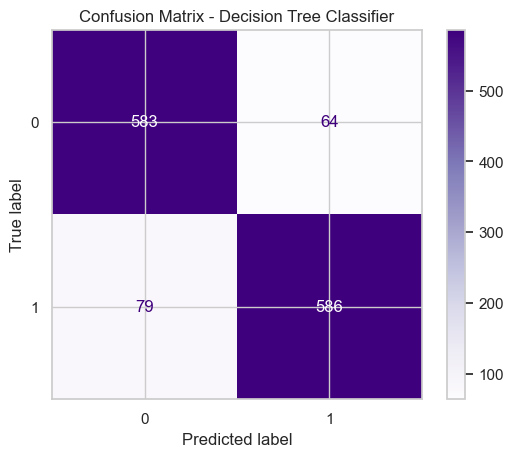

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       647
           1       0.90      0.88      0.89       665

    accuracy                           0.89      1312
   macro avg       0.89      0.89      0.89      1312
weighted avg       0.89      0.89      0.89      1312



In [472]:
decision_tree_classifier = DecisionTreeClassifier(random_state=1)
decision_tree_classifier.fit(training_inputs, training_classes)
tree_predictions = decision_tree_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, tree_predictions, average='weighted')
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier.predict_proba(testing_inputs)[:, 1])

default_results['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, tree_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

print(classification_report(testing_classes, tree_predictions))

# svc

In [473]:
'''svc_classifier = SVC(random_state=1)
svc_classifier.fit(training_inputs, training_classes)
svc_predictions = svc_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, svc_predictions, average='weighted')
accuracy = svc_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, svc_predictions, average='weighted')
auc = roc_auc_score(testing_classes, svc_classifier.decision_function(testing_inputs))

default_results['SVC'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, svc_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix - SVC')
plt.show()

print(classification_report(testing_classes, svc_predictions))'''

"svc_classifier = SVC(random_state=1)\nsvc_classifier.fit(training_inputs, training_classes)\nsvc_predictions = svc_classifier.predict(testing_inputs)\n\nf1 = f1_score(testing_classes, svc_predictions, average='weighted')\naccuracy = svc_classifier.score(testing_inputs, testing_classes)\nrecall = recall_score(testing_classes, svc_predictions, average='weighted')\nauc = roc_auc_score(testing_classes, svc_classifier.decision_function(testing_inputs))\n\ndefault_results['SVC'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}\n\ncm = confusion_matrix(testing_classes, svc_predictions)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm)\ndisp.plot(cmap=plt.cm.Purples)\nplt.title('Confusion Matrix - SVC')\nplt.show()\n\nprint(classification_report(testing_classes, svc_predictions))"

# Naive Bayes

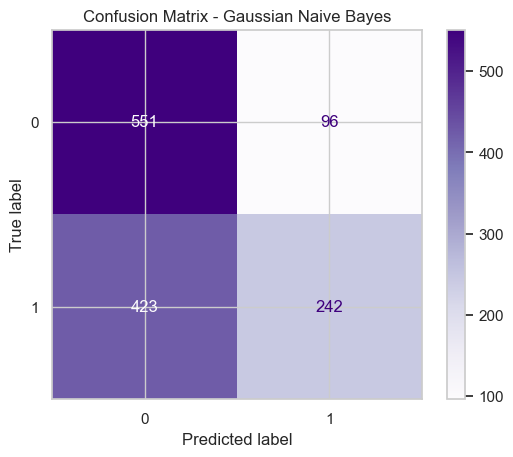

              precision    recall  f1-score   support

           0       0.57      0.85      0.68       647
           1       0.72      0.36      0.48       665

    accuracy                           0.60      1312
   macro avg       0.64      0.61      0.58      1312
weighted avg       0.64      0.60      0.58      1312



In [474]:
gnb_classifier = GaussianNB()
gnb_classifier.fit(training_inputs, training_classes)
gnb_predictions = gnb_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, gnb_predictions, average='weighted')
accuracy = gnb_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, gnb_predictions, average='weighted')
auc = roc_auc_score(testing_classes, gnb_classifier.predict_proba(testing_inputs)[:, 1])

default_results['Gaussian Naive Bayes'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, gnb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

print(classification_report(testing_classes, gnb_predictions))

# Neural networks

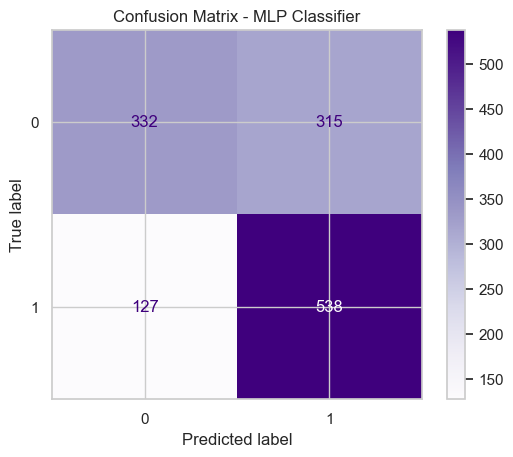

              precision    recall  f1-score   support

           0       0.72      0.51      0.60       647
           1       0.63      0.81      0.71       665

    accuracy                           0.66      1312
   macro avg       0.68      0.66      0.65      1312
weighted avg       0.68      0.66      0.66      1312



In [475]:
mlp_classifier = MLPClassifier(random_state=1, max_iter=1000)
mlp_classifier.fit(training_inputs, training_classes)
mlp_predictions = mlp_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, mlp_predictions, average='weighted')
accuracy = mlp_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, mlp_predictions, average='weighted')
auc = roc_auc_score(testing_classes, mlp_classifier.predict_proba(testing_inputs)[:, 1])

default_results['MLP'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, mlp_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix - MLP Classifier')
plt.show()

print(classification_report(testing_classes, mlp_predictions))

# results

In [476]:
default_results = pd.DataFrame(default_results).T
default_results = default_results.sort_values(by='f1', ascending=False)
default_results

,f1,accuracy,recall,auc
Decision Tree,0.891009,0.891006,0.891006,0.891142
KNN,0.851630,0.852134,0.852134,0.923133
MLP,0.655339,0.663110,0.663110,0.686386
Gaussian Naive Bayes,0.579837,0.604421,0.604421,0.686484


# tentar corrigir a diferença entre true / falses 

### com undersampling

In [477]:
'''from imblearn.under_sampling import RandomUnderSampler

# Realizar o undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Dividir os dados em treino e teste (80-20)
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)

# Treinar e avaliar os modelos com os dados balanceados
undersampling_results = {}

# KNN
knn_classifier.fit(training_inputs, training_classes)
knn_predictions = knn_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, knn_predictions, average='weighted')
accuracy = knn_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# Decision Tree
decision_tree_classifier.fit(training_inputs, training_classes)
tree_predictions = decision_tree_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, tree_predictions, average='weighted')
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# SVC
svc_classifier.fit(training_inputs, training_classes)
svc_predictions = svc_classifier.predict(testing_inputs)# Realizar o undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Dividir os dados em treino e teste (80-20)
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)

# Treinar e avaliar os modelos com os dados balanceados
undersampling_results = {}

# KNN
knn_classifier.fit(training_inputs, training_classes)
knn_predictions = knn_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, knn_predictions, average='weighted')
accuracy = knn_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# Decision Tree
decision_tree_classifier.fit(training_inputs, training_classes)
tree_predictions = decision_tree_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, tree_predictions, average='weighted')
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# SVC
svc_classifier.fit(training_inputs, training_classes)
svc_predictions = svc_classifier.predict(testing_inputs)# Realizar o undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Dividir os dados em treino e teste (80-20)
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)

# Treinar e avaliar os modelos com os dados balanceados
undersampling_results = {}

# KNN
knn_classifier.fit(training_inputs, training_classes)
knn_predictions = knn_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, knn_predictions, average='weighted')
accuracy = knn_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# Decision Tree
decision_tree_classifier.fit(training_inputs, training_classes)
tree_predictions = decision_tree_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, tree_predictions, average='weighted')
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# SVC
svc_classifier.fit(training_inputs, training_classes)
svc_predictions = svc_classifier.predict(testing_inputs)
'''

"from imblearn.under_sampling import RandomUnderSampler\n\n# Realizar o undersampling\nrus = RandomUnderSampler(random_state=42)\nX_resampled, y_resampled = rus.fit_resample(X, y)\n\n# Dividir os dados em treino e teste (80-20)\n(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)\n\n# Treinar e avaliar os modelos com os dados balanceados\nundersampling_results = {}\n\n# KNN\nknn_classifier.fit(training_inputs, training_classes)\nknn_predictions = knn_classifier.predict(testing_inputs)\nf1 = f1_score(testing_classes, knn_predictions, average='weighted')\naccuracy = knn_classifier.score(testing_inputs, testing_classes)\nrecall = recall_score(testing_classes, knn_predictions, average='weighted')\nauc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])\nundersampling_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}\n\n# Decision Tree\n

### com oversampling

In [478]:
'''
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Dividir os dados em treino e teste (80-20)
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)

# Treinar e avaliar os modelos com os dados balanceados
undersampling_results = {}

# KNN
knn_classifier.fit(training_inputs, training_classes)
knn_predictions = knn_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, knn_predictions, average='weighted')
accuracy = knn_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# Decision Tree
decision_tree_classifier.fit(training_inputs, training_classes)
tree_predictions = decision_tree_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, tree_predictions, average='weighted')
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# SVC
svc_classifier.fit(training_inputs, training_classes)
svc_predictions = svc_classifier.predict(testing_inputs)# Realizar o undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Dividir os dados em treino e teste (80-20)
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)

# Treinar e avaliar os modelos com os dados balanceados
undersampling_results = {}

# KNN
knn_classifier.fit(training_inputs, training_classes)
knn_predictions = knn_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, knn_predictions, average='weighted')
accuracy = knn_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# Decision Tree
decision_tree_classifier.fit(training_inputs, training_classes)
tree_predictions = decision_tree_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, tree_predictions, average='weighted')
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# SVC
svc_classifier.fit(training_inputs, training_classes)
svc_predictions = svc_classifier.predict(testing_inputs)# Realizar o undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Dividir os dados em treino e teste (80-20)
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)

# Treinar e avaliar os modelos com os dados balanceados
undersampling_results = {}

# KNN
knn_classifier.fit(training_inputs, training_classes)
knn_predictions = knn_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, knn_predictions, average='weighted')
accuracy = knn_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# Decision Tree
decision_tree_classifier.fit(training_inputs, training_classes)
tree_predictions = decision_tree_classifier.predict(testing_inputs)
f1 = f1_score(testing_classes, tree_predictions, average='weighted')
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier.predict_proba(testing_inputs)[:, 1])
undersampling_results['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

# SVC
svc_classifier.fit(training_inputs, training_classes)
svc_predictions = svc_classifier.predict(testing_inputs)
'''


"\nfrom imblearn.over_sampling import RandomOverSampler\n\nros = RandomOverSampler(random_state=42)\nX_resampled, y_resampled = ros.fit_resample(X_train, y_train)\n\n# Dividir os dados em treino e teste (80-20)\n(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=1)\n\n# Treinar e avaliar os modelos com os dados balanceados\nundersampling_results = {}\n\n# KNN\nknn_classifier.fit(training_inputs, training_classes)\nknn_predictions = knn_classifier.predict(testing_inputs)\nf1 = f1_score(testing_classes, knn_predictions, average='weighted')\naccuracy = knn_classifier.score(testing_inputs, testing_classes)\nrecall = recall_score(testing_classes, knn_predictions, average='weighted')\nauc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])\nundersampling_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}\n\n# Decision Tree\ndecision_tree_cla

# teste

In [479]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=decision_tree,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='f1_weighted')

# Fit the model
grid_search.fit(training_inputs, training_classes)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best estimator
best_decision_tree = grid_search.best_estimator_

# Evaluate on test data
tree_predictions = best_decision_tree.predict(testing_inputs)
f1 = f1_score(testing_classes, tree_predictions, average='weighted')
print(f"Improved Decision Tree F1 Score: {f1}")


Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Improved Decision Tree F1 Score: 0.9138758042122715


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)


# Split the scaled data
training_inputs, testing_inputs, training_classes, testing_classes = train_test_split( X_normalized, y, test_size=0.2, random_state=1)


param_grid = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(training_inputs, training_classes)

print("Best parameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_

# Evaluate on test data
knn_predictions = best_knn.predict(testing_inputs)
f1 = f1_score(testing_classes, knn_predictions, average='weighted')
print(f"Improved KNN F1 Score: {f1}")


# Final File

In [ ]:
# Carregar o dataset de teste
df_test = pd.read_csv('../HealthInsurancePredictor/data/customer_test_masked.csv')

# Preservar a coluna 'custid' antes de qualquer remoção
custid = df_test['custid']

# Aplicar os mesmos pré-processamentos no conjunto de teste
# Drop unnecessary columns
df_test = df_test.drop(columns=['Unnamed: 0', 'custid', 'code_column'], errors='ignore')

# Tratar valores ausentes
df_test['is_employed'] = df_test['is_employed'].fillna('Not in Workforce')

df_test['housing_type'] = df_test['housing_type'].fillna('Unknown')
df_test['num_vehicles'] = df_test['num_vehicles'].fillna(0)
df_test['gas_usage'] = df_test['gas_usage'].fillna(0)
df_test['recent_move_b'] = df_test['recent_move_b'].fillna('Unknown')

# Tratar outliers (exemplo: 'gas_usage' e 'income')
df_test['gas_usage'] = np.log1p(df_test['gas_usage'])
#df_test = df_test[df_test['age'] <= age_upper_limit]
#df_test['age'] = np.log1p(df_test['age'])
df_test.loc[df_test['income'] > income_upper_limit, 'income'] /= 12

# adicionar colunas
df_test['age_group'] = pd.cut(df_test['age'], bins=[-1, 18, 35, 55, 75, 100, 145], labels=[0, 1, 2, 3, 4, 5])
df_test['income_per_vehicle'] = df_test['income'] / (df_test['num_vehicles'] + 1)  # Avoid division by zero
df_test['income_age_interaction'] = df_test['income'] * df_test['age']

# Mapear categorias para numérico (usando os mesmos mapeamentos do treino)
sex_mapping = {'Female': 0, 'Male': 1}
is_employed_mapping = {False: 0, True: 1, 'Not in Workforce': 2}
marital_status_mapping = {'Divorced/Separated': 0, 'Married': 1, 'Never married': 2, 'Widowed': 3}
housing_type_mapping = {'Homeowner free and clear': 0, 'Homeowner with mortgage/loan': 1, 
                        'Occupied with no rent': 2, 'Rented': 3, 'Unknown': 4}
recent_move_b_mapping = {'F': 0, 'T': 1, 'Unknown': 2}

df_test['sex'] = df_test['sex'].map(sex_mapping)
df_test['is_employed'] = df_test['is_employed'].map(is_employed_mapping)
df_test['marital_status'] = df_test['marital_status'].map(marital_status_mapping)
df_test['housing_type'] = df_test['housing_type'].map(housing_type_mapping)
df_test['recent_move_b'] = df_test['recent_move_b'].map(recent_move_b_mapping)

# Label encode 'state_of_res'
state_of_res_le = LabelEncoder()
df_test['state_of_res'] = state_of_res_le.fit_transform(df_test['state_of_res'])

# Preparar os dados para prever
X_test_final = df_test.drop(columns=['health_ins'], errors='ignore')

# Verificar valores ausentes no conjunto de teste
print("\nValores ausentes por coluna no conjunto de teste:")
print(X_test_final.isnull().sum())

# Fazer as previsões usando o modelo treinado
predictions = best_knn.predict(X_test_final)  # ou substitua por `knn_classifier.predict` ou `decision_tree_classifier.predict` conforme o modelo escolhido

# Criar o arquivo de submissão
submission = pd.DataFrame({'custid': custid, 'health_ins': predictions})

# Salvar o arquivo de submissão
submission.to_csv('submission.csv', index=False)

print("Arquivo 'submission.csv' gerado com sucesso!")



Valores ausentes por coluna no conjunto de teste:
sex                       0
is_employed               0
income                    0
marital_status            0
housing_type              0
num_vehicles              0
age                       0
state_of_res              0
gas_usage                 0
rooms                     0
recent_move_b             0
age_group                 0
income_per_vehicle        0
income_age_interaction    0
dtype: int64
Arquivo 'submission.csv' gerado com sucesso!
